In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm     #for progress bar
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument     #used for A single document, made up of `words` (a list of unicode string tokens)
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


**Financial DATASET**

In [3]:
#df = pd.read_csv('/content/drive/MyDrive/sentiment analyser/data.csv')
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/big data project/all-data.csv',encoding='latin-1')
df.columns=['label','text']
df.loc[(df.label == 'negative'),'label']='-1'
df.loc[(df.label == 'neutral'),'label']='0'
df.loc[(df.label == 'positive'),'label']='1'

df = df[pd.notnull(df['text'])]
df.head(10)

,label,text
0,0,Technopolis plans to develop in stages an area...
1,-1,The international electronic industry company ...
2,1,With the new production plant the company woul...
3,1,According to the company 's updated strategy f...
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
5,1,"For the last quarter of 2010 , Componenta 's n..."
6,1,"In the third quarter of 2010 , net sales incre..."
7,1,Operating profit rose to EUR 13.1 mn from EUR ...
8,1,"Operating profit totalled EUR 21.1 mn , up fro..."
9,1,TeliaSonera TLSN said the offer is in line wit...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df.shape 


(4845, 2)

total no of words!

In [5]:
df.index = range(4845)
print("total no of words are:",df['text'].apply(lambda x: len(x.split(' '))).sum())

total no of words are: 111964


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


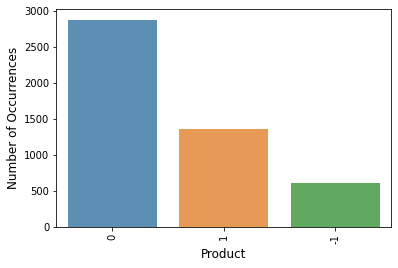

In [6]:
graph = df['label'].value_counts()
plt.figure()
sns.barplot(graph.index, graph.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [7]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text #take data from html files
    text = re.sub(r'\|\|\|', r' ', text) #remove other characters
    text = re.sub(r'http\S+', r'<URL>', text) # remove unuseful data
    text = text.lower() #to convert to lowercase
    #text = text.replace('x', '')
    return text
df['text'] = df['text'].apply(cleanText)
df['text'].head()

0    technopolis plans to develop in stages an area...
1    the international electronic industry company ...
2    with the new production plant the company woul...
3    according to the company 's updated strategy f...
4    financing of aspocomp 's growth aspocomp is ag...
Name: text, dtype: object

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Splitting the train test data in the ratio of 8:2

In [9]:
train, test = train_test_split(df, test_size=0.2)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
print(train_tagged)
print(test_tagged)



272     ([profit, for, the, period, was, eur, 9.8, mn,...
1197    ([competition, authorities, will, have, to, ap...
4796    ([the, steelmaker, said, that, the, drop, in, ...
3309    ([the, other, deal, is, for, process, cranes, ...
4583    ([operating, profit, for, the, six-month, peri...
                              ...                        
3306    ([the, order, is, related, to, renewing, the, ...
3810    ([the, contract, includes, an, option, to, del...
255     ([operating, profit, totaled, eur, 5.5, mn, up...
764     ([in, 2005, cargotec, 's, net, sales, exceeded...
1619    ([the, company, said, production, volumes, so,...
Length: 3876, dtype: object
3709    ([our, key, geographical, markets, are, europe...
3096    ([protalix, is, developing, genetically, engin...
3114    ([scanfil, plc, is, global, contract, manufact...
1503    ([back, then, tikkurila, 's, former, owner, fi...
4611    ([elcoteq, se, is, europe, 's, largest, contra...
                              ...           

In [10]:
train_tagged.values[30]

TaggedDocument(words=['export', 'accounts', 'for', 'about', 'one', 'tenth', 'of', 'the', 'company', "'s", 'annual', 'turnover', 'of', 'one', 'billion', 'kroons'], tags=['0'])

In [11]:
import multiprocessing
cores = multiprocessing.cpu_count()
print(cores)

2


building vocabulary

In [12]:
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 3876/3876 [00:00<00:00, 1215576.66it/s]


Training the model through gensim

In [13]:
%%time
import gensim
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    #decreasing the learning rate
    model_dbow.alpha -= 0.002
    # fix the learning rate, no decay
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 3876/3876 [00:00<00:00, 948213.61it/s]


CPU times: user 7.19 s, sys: 987 ms, total: 8.18 s
Wall time: 5.65 s


Building the Final Vector Feature for the Classifier


In [14]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors
  

Logistic Regression

In [15]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5923632610939112
Testing F1 score: 0.47997905217021297


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Naive Bayes classification 

In [16]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.28792569659442724
Testing F1 score: 0.24559100849487248


Rnndom Forest classification

In [17]:
rfm=RandomForestClassifier(n_estimators=70,oob_score=True,n_jobs=-1,random_state=101,max_features=None,min_samples_leaf=30)
rfm.fit(X_train,y_train)
y_pred=rfm.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5882352941176471
Testing F1 score: 0.49171786405568063


tokenization 

In [18]:
data=open('/content/drive/MyDrive/Colab Notebooks/big data project/deepText1.txt').read()
#tokens = nltk.word_tokenize(data)
#print(tokens)

In [19]:
clean=cleanText(data)

In [20]:
tokenised = tokenize_text(clean)
print(tokenised)

['if', 'you', 'ever', 'saw', 'wooden', 'corporeally', 'hanging', 'in', 'somebody', "'s", 'house', 'or', 'underneath', 'the', 'deck', 'but', 'kind', 'of', 'atlas', 'patoff', 'made', 'big', 'company', 'these', 'wonderfully', 'at', 'beautiful', 'ethel', 'great', 'beyond', 'always', 'had', 'love', 'for', 'babette', 'as', 'gun', 'la', 'is', 'one', 'of', 'the', 'four', 'grand', 'marshal', 'leading', 'new', 'york', 'pride', 'parade', 'this', 'year', 'but', 'in', 'the', 'country', 'he', 'comes', 'from', 'being', 'gay', 'still', 'social', 'taboo', 'the', 'sea', 'of', 'basing', 'based', 'internet', 'company', 'is', 'on', 'mission', 'to', 'improve', 'the', 'in', 'the', 'man', 'you', 'artificial', 'should', 'vitalisation', 'passionless', 'intonation', 'you', 'seaside', 'marcomani', 'blue', 'city', 'runs', 'an', 'apt', 'and', 'website', 'specifically', 'the', 'gay', 'men', 'but', 'is', 'one', 'of', 'the', 'biggest', 'gay', 'social', 'not', 'working', 'at', 'in', 'the', 'world', 'with', 'an', 'estim

In [21]:
pred_lbl = logreg.predict_proba(model_dbow.infer_vector(tokenised).reshape(1, -1))
percent_neg = str('%.2f' % (pred_lbl[0,0]*100))
percent_pos = str('%.2f' % (pred_lbl[0,1]*100))
percent_neu = str('%.2f' % (pred_lbl[0,-1]*100))
print(percent_pos)
print(percent_neg)
print(percent_neu)

58.41
13.64
27.95


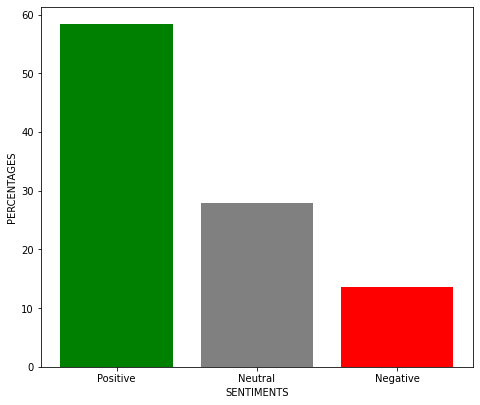

Sentiment: Positive 58.41%
Sentiment: Neutral 27.95%
Sentiment: Negative 13.64%


In [22]:
#For ploting Graph
x=float(percent_pos)
y=float(percent_neg)
z=float(percent_neu)
degrees = 45
fig = plt.figure(figsize=(20,10))    
ax = fig.add_axes([0.1,0.1,0.3,0.5])
names = ['Positive','Neutral','Negative']
values = [x,z,y]
ax.bar(names,values,color=['green','grey','red'])
plt.xlabel('SENTIMENTS')
plt.ylabel('PERCENTAGES',)
plt.savefig('figure_name.pdf', dpi=300)
plt.show()
print('Sentiment: Positive ' + percent_pos + '%')
print('Sentiment: Neutral ' + percent_neu + '%')
print('Sentiment: Negative ' + percent_neg + '%')



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


logistic regression
0.5923632610939112
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       127
           0       0.61      0.95      0.75       585
           1       0.30      0.07      0.11       257

    accuracy                           0.59       969
   macro avg       0.30      0.34      0.29       969
weighted avg       0.45      0.59      0.48       969



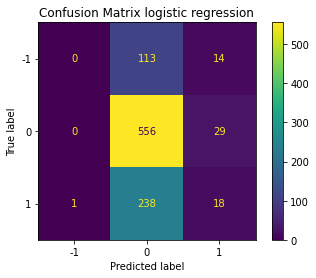

naive bayes
0.28792569659442724
              precision    recall  f1-score   support

          -1       0.18      0.39      0.24       127
           0       0.76      0.10      0.18       585
           1       0.27      0.66      0.39       257

    accuracy                           0.29       969
   macro avg       0.41      0.38      0.27       969
weighted avg       0.56      0.29      0.25       969



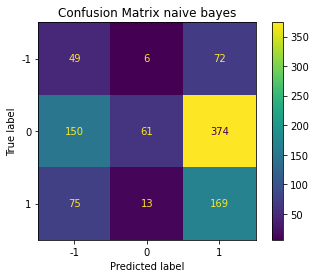

random forest
0.5820433436532507
              precision    recall  f1-score   support

          -1       0.41      0.06      0.10       127
           0       0.63      0.88      0.73       585
           1       0.33      0.18      0.23       257

    accuracy                           0.58       969
   macro avg       0.46      0.37      0.35       969
weighted avg       0.52      0.58      0.52       969



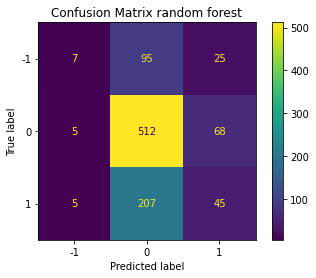

In [23]:
names = [ 'logistic regression', 'naive bayes', 'random forest']
#Test the algorithm on the test data set
n_classes = 3
Classifiers = [
    LogisticRegression(),
    GaussianNB(),
    RandomForestClassifier(max_depth = 50, n_estimators = 50),
    ]
models = zip(names, Classifiers)
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(model, X_test, y_test, values_format='d')
    plt.title(f"Confusion Matrix {name}")
    plt.savefig(f"/content/{name}.png")
    plt.show()